## 1. Import Libraries

In [34]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time

## 2. API Binance

In [35]:
base_url = "https://api.binance.com/api/v3/klines"

In [36]:
#Parametres search

symbol = "BTCUSDT" #Bitcoin (BTC/USDT)
interval = "1h" #Time interval
limit = 1000 #Data to take

In [37]:
#API apply

params = {
    "symbol" : symbol,
    "interval" : interval,
    "limit" : limit
}
response = requests.get(base_url, params= params)

#Convert data in json

data = response.json()

In [38]:
#Create the DataSet

df_cripto = pd.DataFrame(data, columns= ["timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
    ])

df_cripto.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base,taker_buy_quote,ignore
0,1735952400000,97950.01000000,98095.06000000,97800.00000000,98040.00000000,292.09859000,1735955999999,28611491.61131120,64925,159.17303000,15592662.71363720,0
1,1735956000000,98040.00000000,98314.15000000,97848.48000000,98304.51000000,368.90158000,1735959599999,36171507.86031750,67580,221.96194000,21766315.98949260,0
2,1735959600000,98304.51000000,98304.51000000,98052.97000000,98200.00000000,274.68850000,1735963199999,26968830.43148270,42002,132.64343000,13022081.35455400,0
3,1735963200000,98200.01000000,98200.01000000,97862.87000000,98001.00000000,304.49957000,1735966799999,29830355.81246730,52442,148.18614000,14516334.73113070,0
4,1735966800000,98001.00000000,98196.51000000,97988.76000000,98126.21000000,249.97787000,1735970399999,24525804.45248260,39928,140.56781000,13790683.41060510,0


In [39]:
#Convert data to numeric and dates

df_cripto["timestamp"] = pd.to_datetime(df_cripto["timestamp"], unit = "ms")
df_cripto["open"] = df_cripto["open"].astype(float)
df_cripto["high"] = df_cripto["high"].astype(float)
df_cripto["low"] = df_cripto["low"].astype(float)
df_cripto["close"] = df_cripto["close"].astype(float)
df_cripto["volume"] = df_cripto ["volume"].astype(float)

print(df_cripto[["timestamp", "open", "high", "low", "close", "volume"]].head(10))

            timestamp      open      high       low     close     volume
0 2025-01-04 01:00:00  97950.01  98095.06  97800.00  98040.00  292.09859
1 2025-01-04 02:00:00  98040.00  98314.15  97848.48  98304.51  368.90158
2 2025-01-04 03:00:00  98304.51  98304.51  98052.97  98200.00  274.68850
3 2025-01-04 04:00:00  98200.01  98200.01  97862.87  98001.00  304.49957
4 2025-01-04 05:00:00  98001.00  98196.51  97988.76  98126.21  249.97787
5 2025-01-04 06:00:00  98126.21  98209.70  98039.91  98127.54  211.92338
6 2025-01-04 07:00:00  98127.53  98350.04  98095.17  98271.88  454.46141
7 2025-01-04 08:00:00  98271.87  98306.22  97905.26  97906.07  303.67578
8 2025-01-04 09:00:00  97906.08  97980.00  97532.58  97690.37  671.79150
9 2025-01-04 10:00:00  97690.37  97859.60  97600.00  97789.32  330.68560


In [40]:
df_cripto = df_cripto[["timestamp", "open", "high", "low", "close", "volume", "number_of_trades"]]

In [41]:
df_cripto.info()
df_cripto.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         1000 non-null   datetime64[ns]
 1   open              1000 non-null   float64       
 2   high              1000 non-null   float64       
 3   low               1000 non-null   float64       
 4   close             1000 non-null   float64       
 5   volume            1000 non-null   float64       
 6   number_of_trades  1000 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 54.8 KB


,timestamp,open,high,low,close,volume,number_of_trades
0,2025-01-04 01:00:00,97950.01,98095.06,97800.00,98040.00,292.09859,64925
1,2025-01-04 02:00:00,98040.00,98314.15,97848.48,98304.51,368.90158,67580
2,2025-01-04 03:00:00,98304.51,98304.51,98052.97,98200.00,274.68850,42002
3,2025-01-04 04:00:00,98200.01,98200.01,97862.87,98001.00,304.49957,52442
4,2025-01-04 05:00:00,98001.00,98196.51,97988.76,98126.21,249.97787,39928
5,2025-01-04 06:00:00,98126.21,98209.70,98039.91,98127.54,211.92338,40710
6,2025-01-04 07:00:00,98127.53,98350.04,98095.17,98271.88,454.46141,50261
7,2025-01-04 08:00:00,98271.87,98306.22,97905.26,97906.07,303.67578,46767
8,2025-01-04 09:00:00,97906.08,97980.00,97532.58,97690.37,671.79150,83000
9,2025-01-04 10:00:00,97690.37,97859.60,97600.00,97789.32,330.68560,63716


## 3. Feature Creation

In [ ]:
# Simple Media (SMA)

df_cripto["SMA_7"]

## 4. Data Visualization (Mini EDA)

In [42]:
sns.set_style("darkgrid")

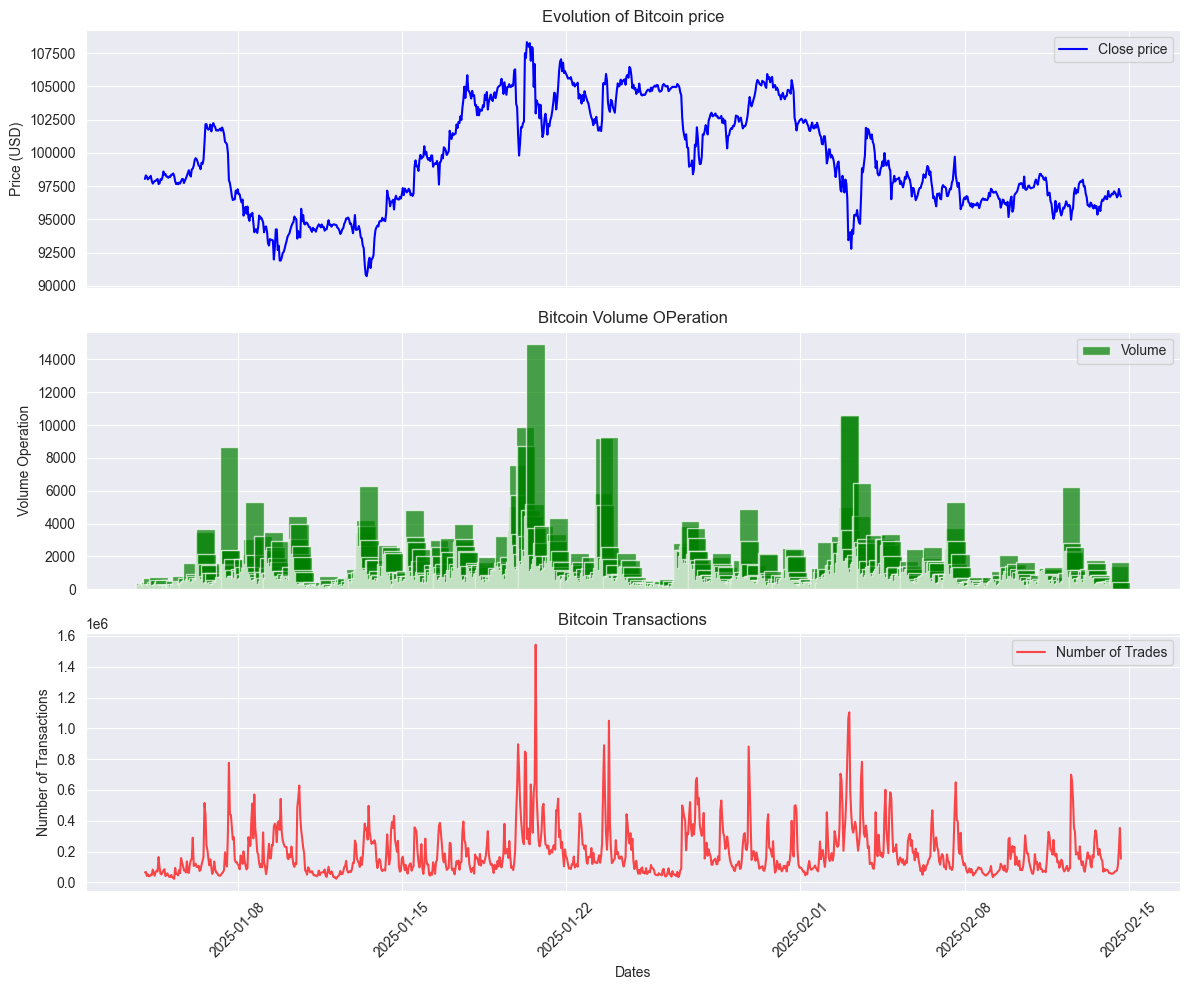

In [43]:
fig, axes = plt.subplots(3,1, figsize= (12,10), sharex = True)

# Evolution of Bitcoin Price Graphic

axes[0].plot(df_cripto["timestamp"], df_cripto["close"], color= "blue", label= "Close price")
axes[0].set_ylabel("Price (USD)")
axes[0].set_title("Evolution of Bitcoin price")
axes[0].legend()

# Volume Operation Graphic
axes[1].bar(df_cripto["timestamp"], df_cripto["volume"],color = "green",alpha= 0.7, label = "Volume")
axes[1].set_ylabel("Volume Operation")
axes[1].set_title("Bitcoin Volume OPeration")
axes[1].legend()

# Number of Transactions Graphic
axes[2].plot(df_cripto["timestamp"], df_cripto["number_of_trades"], color= "red", alpha= 0.7, label= "Number of Trades")
axes[2].set_ylabel("Number of Transactions")
axes[2].set_title("Bitcoin Transactions")
axes[2].legend()

# Format X axis
plt.xticks(rotation = 45)
plt.xlabel("Dates")
plt.tight_layout()

#Show
plt.show()

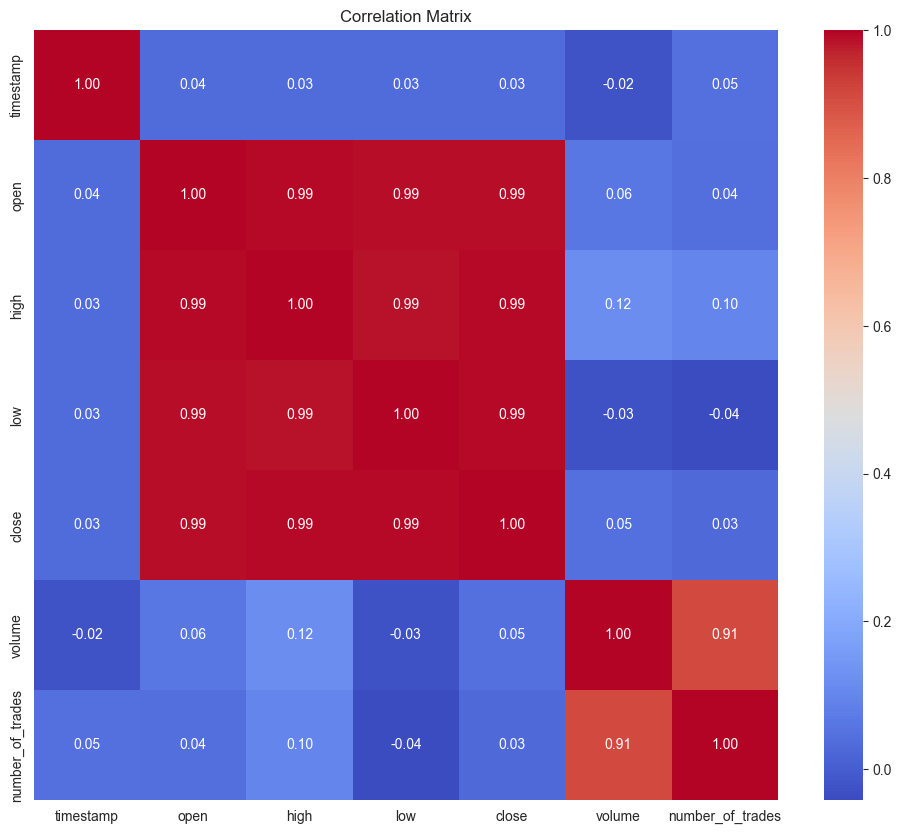

In [44]:
# Correlation

plt.figure(figsize=(12,10))
sns.heatmap(df_cripto.corr(), annot= True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

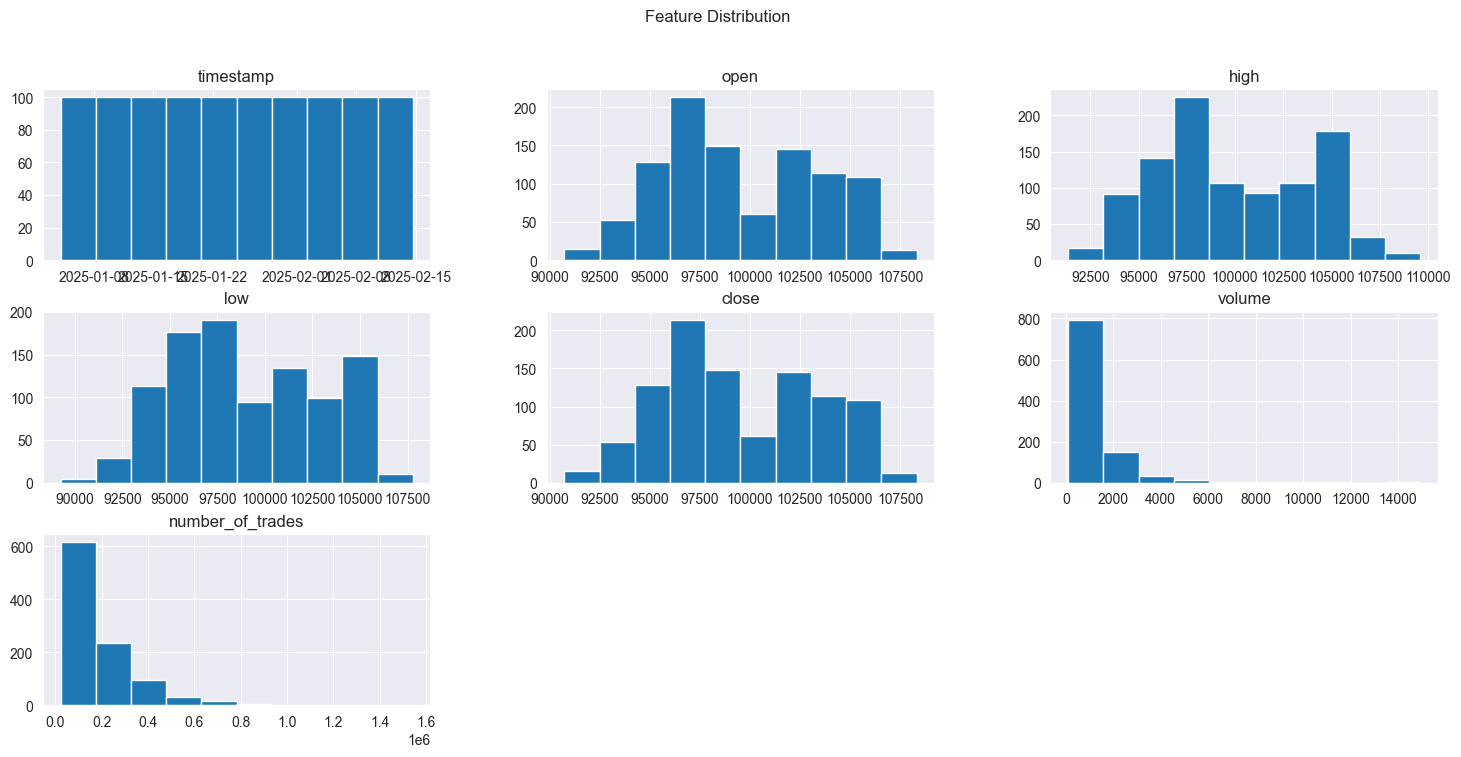

In [50]:
#Feature Distribution

df_cripto.hist(figsize=(18,8))
plt.suptitle("Feature Distribution")
plt.show()

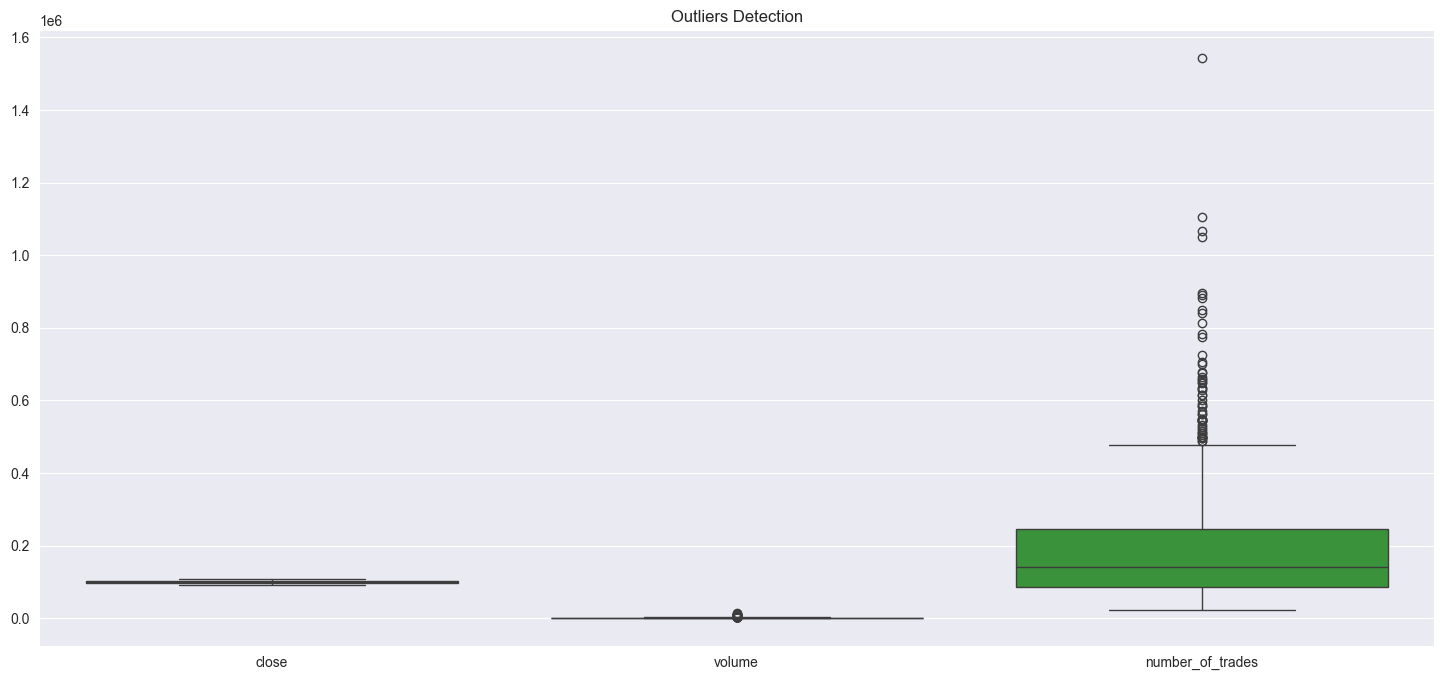

In [51]:
#Outliers

plt.figure(figsize=(18, 8))
sns.boxplot(data=df_cripto[["close", "volume", "number_of_trades"]])
plt.title("Outliers Detection")
plt.show()

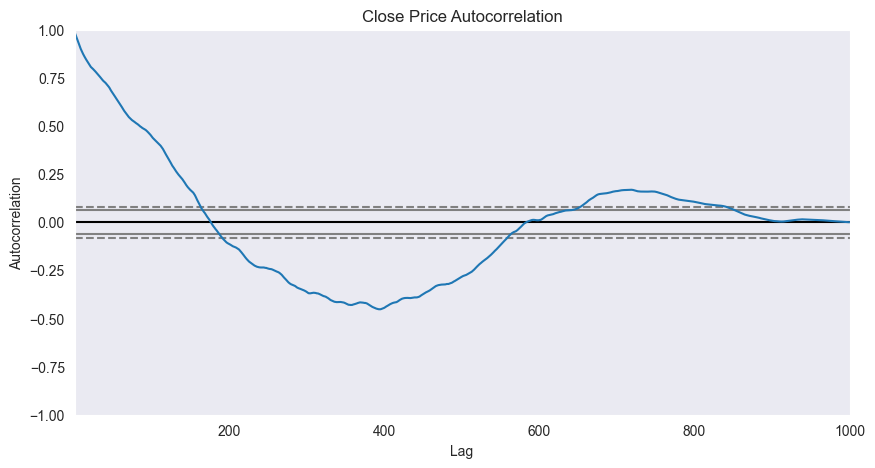

In [52]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize= (10,5))
autocorrelation_plot(df_cripto["close"])
plt.title("Close Price Autocorrelation")
plt.show()